In [5]:
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import *
from pyspark.sql.functions import stddev_pop, avg,stddev
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier
import pyspark.sql.functions as F
from pyspark.mllib.linalg import Matrices
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql import SparkSession

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

In [7]:
#Data = pd.read_csv("https://github.com/bigdata-i523/hid328/blob/master/project/data/german_credit.csv")
rawData = pd.read_csv("../data/credit-data.csv", header=0)

In [8]:
rawData.head(5)

,Creditability,Account_Balance,Duration_of_Credit,Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,employment,Instalment_percent,Sex_MaritalStatus,...,Duration_address,asset,Age,Concurrent_Credits,Type_apartment,No_of_Credits,Occupation,dependents,Telephone,Foreign_Worker
0,good,1,18,critical/other existing credit,used car,1049,1,2,4,male: single,...,4,2,21,3,free apartment,1,3,1,yes,yes
1,good,1,9,critical/other existing credit,other,2799,1,3,2,male: married / widowed,...,2,1,36,3,free apartment,2,3,2,yes,yes
2,good,2,12,existing paid,retraining,841,2,4,2,male: single,...,4,1,23,3,free apartment,1,2,1,yes,yes
3,good,1,12,critical/other existing credit,other,2122,1,3,3,male: married / widowed,...,2,1,39,3,free apartment,2,2,2,yes,no
4,good,1,12,critical/other existing credit,other,2171,1,3,4,male: married / widowed,...,4,2,38,1,rented flat,2,2,1,yes,no


In [9]:
rawData.shape

(1000, 21)

In [10]:

rawData['Creditability'].replace({'bad':0,'good':1},inplace=True)


In [11]:
rawData['Foreign_Worker'].replace({'no':2,'yes':1},inplace=True)

In [12]:
rawData['Telephone'].replace({'no':2,'yes':1},inplace=True)

In [13]:
def Previous_Credit_condition(value):
    if value.strip() == 'critical/other existing credit':
        return 4
    if value.strip() == 'existing paid':
        return 2
    if value.strip() == 'all paid':
        return 1
    if value.strip() == 'delayed previously':
        return 3
    if value.strip() == 'no credits/all paid':
        return 0
    

In [14]:
def Purpose_condition(value):
    if value.strip() == 'new car':
        return 1
    if value.strip() == 'used car':
        return 2
    if value.strip() == 'items of furniture':
        return 3
    if value.strip() == 'radio / television':
        return 4
    if value.strip() == 'household appliances':
        return 5
    if value.strip() == 'repair':
        return 6
    if value.strip() == 'education':
        return 7
    if value.strip() == 'vacation':
        return 8
    if value.strip() == 'retraining':
        return 9
    if value.strip() == 'business':
        return 10
    if value.strip() == 'other':
        return 0

In [15]:
def Sex_MaritalStatus_condition(value):
    if value.strip() == 'male: divorced / living apart':
        return 1
    if value.strip() == 'male: single':
        return 2
    if value.strip() == 'male: married / widowed':
        return 3
    if value.strip() == 'female:':
        return 4
    

In [16]:
def Guarantors_condition(value):
    if value.strip() == 'none':
        return 1
    if value.strip() == 'Co-Applicant':
        return 2
    if value.strip() == 'Guarantor':
        return 3

In [17]:
def Type_apartment_condition(value):
    if value.strip() == 'free apartment':
        return 1
    if value.strip() == 'rented flat':
        return 2
    if value.strip() == 'owner-occupied flat':
        return 3

In [18]:
rawData['Previous_Credit'] = rawData['Previous_Credit'].apply(Previous_Credit_condition)
rawData['Purpose'] = rawData['Purpose'].apply(Purpose_condition)
rawData['Sex_MaritalStatus'] = rawData['Sex_MaritalStatus'].apply(Sex_MaritalStatus_condition)
rawData['Guarantors'] = rawData['Guarantors'].apply(Guarantors_condition)
rawData['Type_apartment'] = rawData['Type_apartment'].apply(Type_apartment_condition)

In [19]:
rawData.head(5)

,Creditability,Account_Balance,Duration_of_Credit,Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,employment,Instalment_percent,Sex_MaritalStatus,...,Duration_address,asset,Age,Concurrent_Credits,Type_apartment,No_of_Credits,Occupation,dependents,Telephone,Foreign_Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


In [20]:
%matplotlib inline
sn.set(color_codes=True)

In [21]:

spark = SparkSession.builder.appName("analytics").master("local").getOrCreate()
csvDF = spark.createDataFrame(rawData)
#csvDF = spark.read.format("csv").option("header","true").option("inferSchema", "true").load("../data/german_credit.csv")

In [22]:
csvPandas=rawData

In [23]:
csvPandas.head(10)

,Creditability,Account_Balance,Duration_of_Credit,Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,employment,Instalment_percent,Sex_MaritalStatus,...,Duration_address,asset,Age,Concurrent_Credits,Type_apartment,No_of_Credits,Occupation,dependents,Telephone,Foreign_Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2
5,1,1,10,4,0,2241,1,2,1,3,...,3,1,48,3,1,2,2,2,1,2
6,1,1,8,4,0,3398,1,4,1,3,...,4,1,39,3,2,2,2,1,1,2
7,1,1,6,4,0,1361,1,2,2,3,...,4,1,40,3,2,1,2,2,1,2
8,1,4,18,4,3,1098,1,1,4,2,...,4,3,65,3,2,2,1,1,1,1
9,1,2,24,2,3,3758,3,1,1,2,...,4,4,23,3,1,1,1,1,1,1


Text(0,0.5,'Frequency')

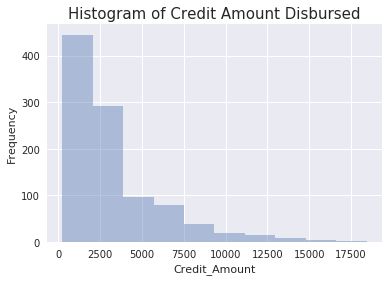

In [19]:
sn.distplot(csvPandas.Credit_Amount, kde = False,bins=10 )
plt.title( "Histogram of Credit Amount Disbursed", fontsize = 15)
plt.ylabel( "Frequency")


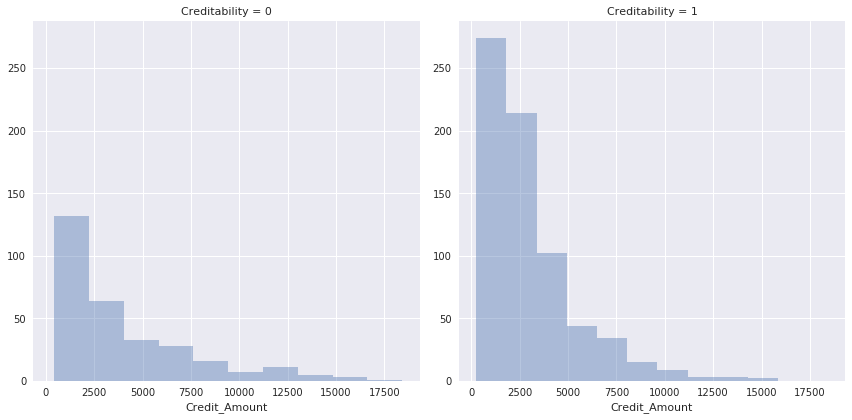

In [20]:
g = sn.FacetGrid(csvPandas, col="Creditability", size = 6)
g.map(sn.distplot, "Credit_Amount", kde = False, bins = 10 )

Text(0,0.5,'Frequency')

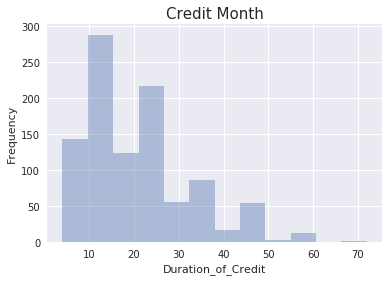

In [21]:
sn.distplot(csvPandas.Duration_of_Credit, kde = False,bins=12)
plt.title( "Credit Month", fontsize = 15)
plt.ylabel( "Frequency")

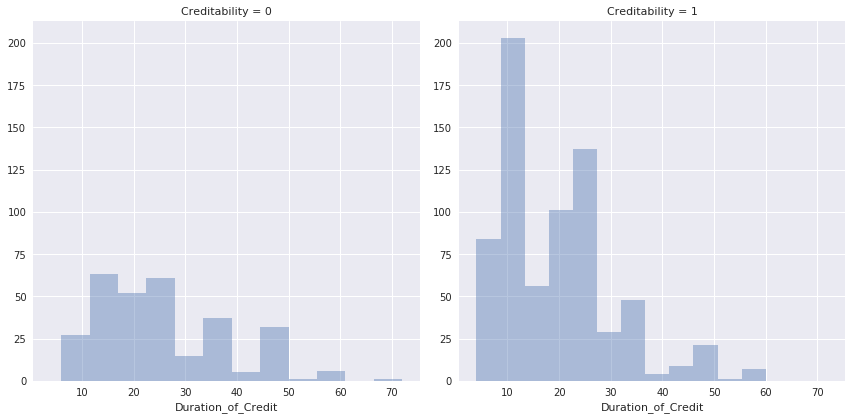

In [22]:
g = sn.FacetGrid(csvPandas, col="Creditability", size = 6)
g.map(sn.distplot, "Duration_of_Credit", kde = False, bins = 12)

Text(0,0.5,'Frequency')

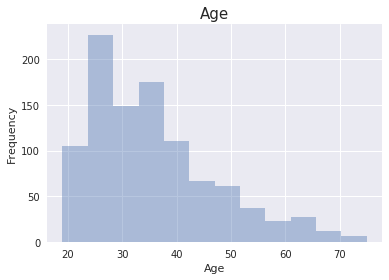

In [23]:
sn.distplot(csvPandas.Age, kde = False,bins=12)
plt.title( "Age", fontsize = 15)
plt.ylabel( "Frequency")

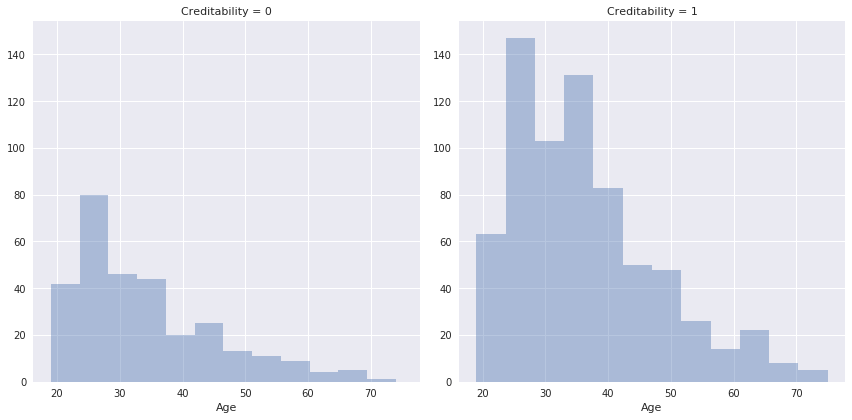

In [24]:
g = sn.FacetGrid(csvPandas, col="Creditability", size = 6)
g.map(sn.distplot, "Age", kde = False, bins = 12)

In [25]:
csvDF.select("Creditability").groupBy("Creditability").count().show()

+-------------+-----+
|Creditability|count|
+-------------+-----+
|            0|  300|
|            1|  700|
+-------------+-----+



In [26]:
rows=[]
rows.append((csvPandas['Credit_Amount'].min(),csvPandas.Credit_Amount.quantile(.25),csvPandas['Credit_Amount'].median(),csvPandas['Credit_Amount'].mean(),csvPandas.Credit_Amount.quantile(.75),csvPandas['Credit_Amount'].max()))
crAmountPerc = pd.DataFrame(rows,columns=["Min","1st Qu","Median","Mean","3rd Qu","Max"])
crAmountPerc.head()

,Min,1st Qu,Median,Mean,3rd Qu,Max
0,250,1365.5,2319.5,3271.248,3972.25,18424


In [327]:
dcrows=[]
dcrows.append((csvPandas['Duration_of_Credit'].min(),csvPandas.Duration_of_Credit.quantile(.25),csvPandas['Duration_of_Credit'].median(),csvPandas['Duration_of_Credit'].mean(),csvPandas.Duration_of_Credit.quantile(.75),csvPandas['Duration_of_Credit'].max()))
dcPerc = pd.DataFrame(dcrows,columns=["Min","1st Qu","Median","Mean","3rd Qu","Max"])
dcPerc.head()

,Min,1st Qu,Median,Mean,3rd Qu,Max
0,4,12.0,18.0,20.903,24.0,72


In [328]:
Agerows=[]
Agerows.append((csvPandas['Age'].min(),csvPandas.Age.quantile(.25),csvPandas['Age'].median(),csvPandas['Age'].mean(),csvPandas.Age.quantile(.75),csvPandas['Age'].max()))
agePerc = pd.DataFrame(Agerows,columns=["Min","1st Qu","Median","Mean","3rd Qu","Max"])
agePerc.head()

,Min,1st Qu,Median,Mean,3rd Qu,Max
0,19,27.0,33.0,35.542,42.0,75


In [329]:
data=csvDF.rdd.map(lambda x:(Vectors.dense(x[1:]), float(x[0]))).toDF(["features", "label"])

In [330]:
r = ChiSquareTest.test(data, "features", "label").head()

In [331]:
pdf=pd.DataFrame({'All':csvDF.columns[1:],'PValues':r.pValues.values,'Chi^2':r.statistics.values,'D.F':r.degreesOfFreedom})
pdf.head(21)

,All,Chi^2,D.F,PValues
0,Account_Balance,123.720944,3,0.000000e+00
1,Duration_of_Credit,78.886937,32,7.784572e-06
2,Previous_Credit,61.691397,4,1.279199e-12
3,Purpose,33.356447,9,1.157491e-04
4,Credit_Amount,931.746032,922,4.045155e-01
5,Value_Savings_Stocks,36.098928,4,2.761214e-07
6,employment,18.368274,4,1.045452e-03
7,Instalment_percent,5.476792,3,1.400333e-01
8,Sex_MaritalStatus,9.605214,3,2.223801e-02
9,Guarantors,6.645367,2,3.605595e-02


In [332]:
dataPanda = data.toPandas()
dataPanda.head(5)

,features,label
0,"[1.0, 18.0, 4.0, 2.0, 1049.0, 1.0, 2.0, 4.0, 2...",1.0
1,"[1.0, 9.0, 4.0, 0.0, 2799.0, 1.0, 3.0, 2.0, 3....",1.0
2,"[2.0, 12.0, 2.0, 9.0, 841.0, 2.0, 4.0, 2.0, 2....",1.0
3,"[1.0, 12.0, 4.0, 0.0, 2122.0, 1.0, 3.0, 3.0, 3...",1.0
4,"[1.0, 12.0, 4.0, 0.0, 2171.0, 1.0, 3.0, 4.0, 3...",1.0


In [333]:
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Logistic Regression

In [334]:
lrEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [335]:
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
lrModel = lr.fit(trainingData)
lrPredictions = lrModel.transform(testData)
lrEvaluator.evaluate(lrPredictions)

0.752442996742671

In [336]:
lrMetricsData = lrPredictions.select("label","prediction")
pandaLrMetrics=lrMetricsData.groupby("label","prediction").count().toPandas()
pivotedLr = pandaLrMetrics.pivot(index='label', columns='prediction', values='count')
pivotedLr.head(5)

prediction,0.0,1.0
label,,
0.0,33,57
1.0,19,198


In [337]:
lrModel.coefficients

DenseVector([0.5218, -0.0329, 0.3496, -0.0089, -0.0001, 0.231, 0.1235, -0.3162, 0.1185, 0.1081, -0.1125, -0.1493, 0.0139, -0.0198, 0.1083, -0.3016, -0.1169, -0.3836, 0.1954, -0.4088])

In [338]:
print 'Model Intercept: ', lrModel.intercept

Model Intercept:  0.754088809424


# Decision Tree

In [339]:
dtEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [340]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features",maxDepth=3,maxBins=20)

In [341]:
dtModel=dt.fit(trainingData)
dtPredictions=dtModel.transform(testData)
dtEvaluator.evaluate(dtPredictions)

0.749185667752443

In [342]:
print("Bins :",dt.getMaxBins())
print("Depth :",dt.getMaxDepth())

('Bins :', 20)
('Depth :', 3)


In [343]:
dtPredictionsPanda = dtPredictions.toPandas()
dtPredictionsPanda.head(5)

,features,label,rawPrediction,probability,prediction
0,"[1.0, 6.0, 2.0, 0.0, 14896.0, 1.0, 5.0, 1.0, 3...",0.0,"[35.0, 104.0]","[0.251798561151, 0.748201438849]",1.0
1,"[1.0, 6.0, 2.0, 2.0, 1374.0, 1.0, 3.0, 1.0, 3....",1.0,"[35.0, 104.0]","[0.251798561151, 0.748201438849]",1.0
2,"[1.0, 6.0, 2.0, 3.0, 2647.0, 3.0, 3.0, 2.0, 3....",1.0,"[35.0, 104.0]","[0.251798561151, 0.748201438849]",1.0
3,"[1.0, 6.0, 4.0, 0.0, 1361.0, 1.0, 2.0, 2.0, 3....",1.0,"[35.0, 104.0]","[0.251798561151, 0.748201438849]",1.0
4,"[1.0, 6.0, 4.0, 2.0, 3384.0, 1.0, 3.0, 1.0, 1....",0.0,"[35.0, 104.0]","[0.251798561151, 0.748201438849]",1.0


In [344]:
dtMetricsData = dtPredictions.select("label","prediction")
pandaDtMetrics=dtMetricsData.groupby("label","prediction").count().toPandas()
pivotedDt = pandaDtMetrics.pivot(index='label', columns='prediction', values='count')
pivotedDt.head(5)

prediction,0.0,1.0
label,,
0.0,39,51
1.0,26,191


In [345]:
dtPenalty=pivotedDt.values[0][1]*5+pivotedDt.values[1][0]
print(dtPenalty)

281


# Random Forest

In [346]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
rfModel = rf.fit(trainingData)

In [347]:
print("number of Classes :"+str(rfModel.numClasses))

number of Classes :2


In [348]:
print("number of Features :"+str(rfModel.numFeatures))

number of Features :20


In [349]:
print("Total number of Nodes :"+str(rfModel.totalNumNodes))

Total number of Nodes :954


In [350]:
print "Max Bins",rf.getMaxBins()

print "Max Trees",rf.getNumTrees()
print "Max Depth",rf.getMaxDepth()

Max Bins 32
Max Trees 20
Max Depth 5


In [351]:

rfEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
#evaluator.evaluate(predictions)

In [352]:
paramGridRf = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [200])
             .build())

In [353]:
rfCv = CrossValidator(estimator=rf, estimatorParamMaps=paramGridRf, evaluator=rfEvaluator, numFolds=2)

In [354]:
rfCvModel = rfCv.fit(trainingData)

In [355]:
rfPredictions = rfCvModel.transform(testData)

In [356]:
rfEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")


In [357]:
rfEvaluator.evaluate(rfPredictions)


0.755700325732899

In [358]:


print "Max Trees",rfCvModel.bestModel.getNumTrees


Max Trees 200


In [359]:
bestModel = rfCvModel.bestModel
finalPredictions = bestModel.transform(data)
rfEvaluator.evaluate(finalPredictions)

0.842

In [360]:
rfPredictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[1.0,6.0,2.0,0.0,...|  0.0|[99.3872047197162...|[0.49693602359858...|       1.0|
|[1.0,6.0,2.0,2.0,...|  1.0|[44.7516028618355...|[0.22375801430917...|       1.0|
|[1.0,6.0,2.0,3.0,...|  1.0|[25.9733073677661...|[0.12986653683883...|       1.0|
|[1.0,6.0,4.0,0.0,...|  1.0|[27.4420104680349...|[0.13721005234017...|       1.0|
|[1.0,6.0,4.0,2.0,...|  0.0|[45.9512845994564...|[0.22975642299728...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [361]:
metricsData = rfPredictions.select("label","prediction")
sDF=metricsData.groupby("label","prediction").count()
pandaSDF=sDF.toPandas()
df2 = pandaSDF.pivot(index='label', columns='prediction', values='count')
df2.head(5)

prediction,0.0,1.0
label,,
0.0,29,61
1.0,14,203


In [362]:
penalty=df2.values[0][1]*5+df2.values[1][0]
print(penalty)

319


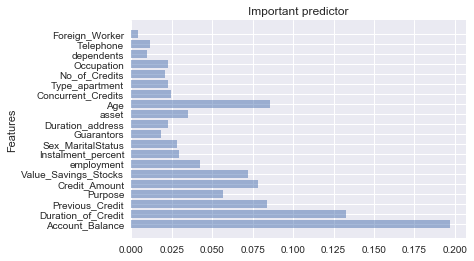

In [363]:
pdf=pd.DataFrame({'All':csvDF.columns[1:],'Important':bestModel.featureImportances.values},columns=['All','Important'])
objects = csvDF.columns[1:]
y_pos = np.arange(len(csvDF.columns[1:]))
performance = bestModel.featureImportances.values
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.ylabel('Features')
plt.title('Important predictor')

plt.show()


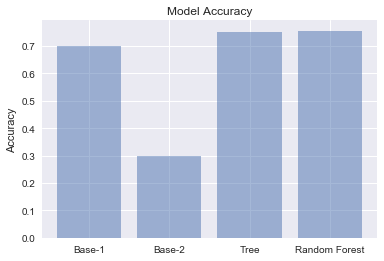

In [364]:
objects = ('Base-1', 'Base-2', 'Tree', 'Random Forest')
y_pos = np.arange(len(objects))
performance = [.7,.3,dtEvaluator.evaluate(dtPredictions),rfEvaluator.evaluate(rfPredictions)]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
 
plt.show()

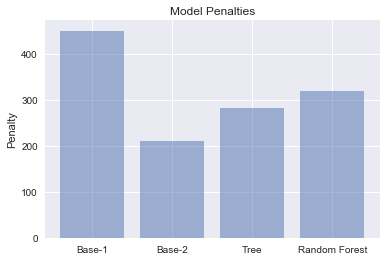

In [365]:
objects = ('Base-1', 'Base-2', 'Tree', 'Random Forest')
y_pos = np.arange(len(objects))
performance = [450,210,dtPenalty,penalty]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Penalty')
plt.title('Model Penalties')
 
plt.show()

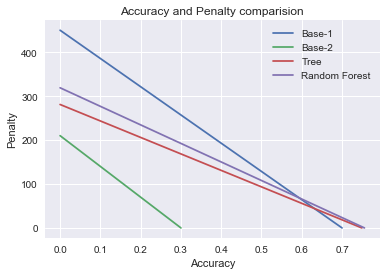

In [366]:

datax1=[.7,.3,dtEvaluator.evaluate(dtPredictions),rfEvaluator.evaluate(rfPredictions)]
datay1=[0,0,0,0]

datax2=[0,0,0,0]
datay2=[450,210,dtPenalty,penalty]
models =['Base-1','Base-2','Tree','Random Forest']

fig,ax = plt.subplots()
for i in range(len(datax1)):
    x = (datax1[i], datax2[i])
    y = (datay1[i], datay2[i]) 
    ax.plot(x, y,label=models[i])
ax.legend()
plt.title("Accuracy and Penalty comparision")
plt.xlabel("Accuracy")
plt.ylabel("Penalty")
plt.show()

